In [19]:
!gdown 1pE2puCp0KKkLPgDgvlQCEvAVUXauFPca

Downloading...
From: https://drive.google.com/uc?id=1pE2puCp0KKkLPgDgvlQCEvAVUXauFPca
To: /content/Copy of FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 85.8MB/s]


In [20]:
!unzip Copy\ of\ FruitinAmazon.zip

Archive:  Copy of FruitinAmazon.zip
replace FruitinAmazon/test/cupuacu/download (5).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization, Activation, Convolution2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


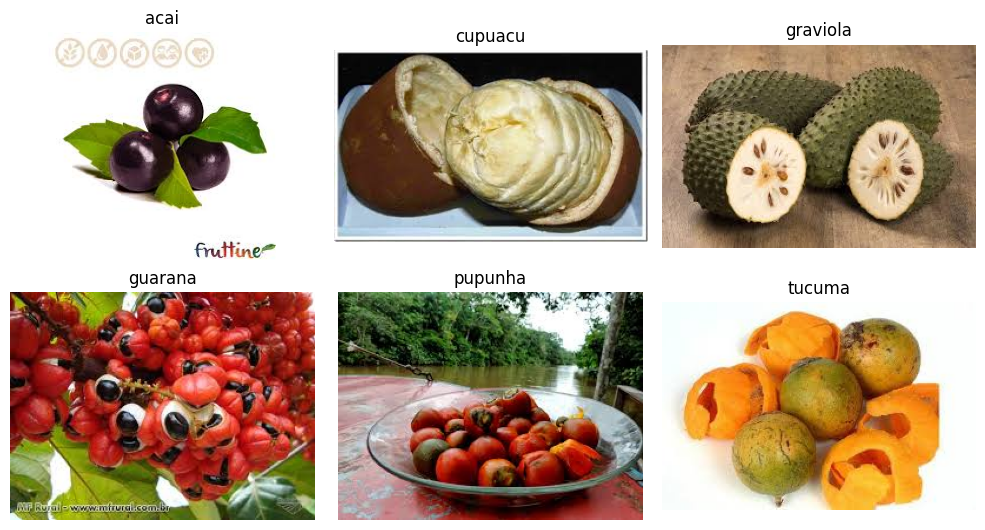

In [22]:
train_dir = "/content/FruitinAmazon/train"
test_dir = "/content/FruitinAmazon/test"

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(class_names)

class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


plt.figure(figsize=(10,8))
for i, class_name in enumerate(class_names):
  class_dir = os.path.join(train_dir, class_name)
  images = os.listdir(class_dir)
  img_name = random.choice(images)
  img_path = os.path.join(class_dir, img_name)
  img = Image.open(img_path)

  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title(class_name)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
#checking corrupted images
corrupted = []
for class_name in class_names:
  class_dir = os.path.join(train_dir, class_name)
  for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    try:
      img = Image.open(img_path)
      img.verify()
    except:
      corrupted.append(img_path)
      os.remove(img_path)
      print(f"Removed corrupted image:{img_path}")

if not corrupted:
  print("No corrupted images found.")

No corrupted images found.


In [24]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = True,
    validation_split = validation_split,
    subset = 'training',
    seed = 123
)

train_ds = train_ds.map(lambda x, y: (rescale(x),y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False,
    validation_split = validation_split,
    subset = 'validation',
    seed = 123
)

val_ds = val_ds.map(lambda x, y: (rescale(x),y))



Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


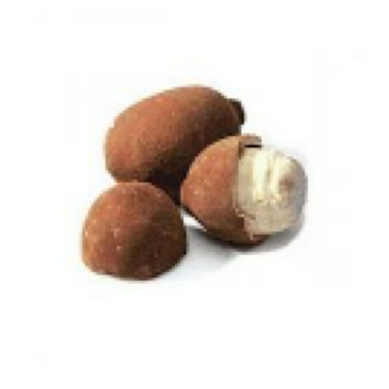

In [25]:
for images, _ in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"))
    plt.axis("off")
    plt.show()

In [26]:
data_augmentation_layers = [
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
]
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

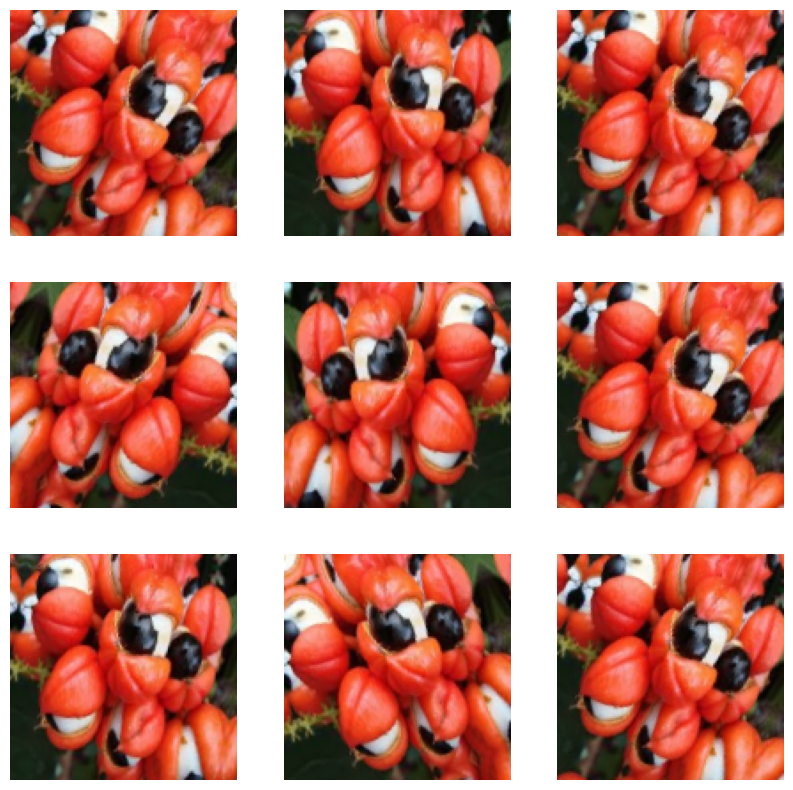

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("float32"))
    plt.axis("off")

In [28]:
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

model = tf.keras.Sequential([
  # Data augmentation applied using Lambda layer
  tf.keras.layers.Input( shape=(img_height, img_width, 3)),
  # Rescaling layer to normalize pixel values
  tf.keras.layers.Rescaling(1./255),
  # First Convolutional Block
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=None),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),
  Dropout(0.25),
  # Second Convolutional Block
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=None),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),
  Dropout(0.25),
  # Third Convolutional Block
  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=None),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),
  Dropout(0.25),
  # Fourth Convolutional Block
  tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation=None),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2)),
  Dropout(0.25),
  # Flatten the output of the last Conv2D layer
  Flatten(),
  # First Fully Connected Layer
  Dense(512, activation=None),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.5),
  # Second Fully Connected Layer
  Dense(256, activation=None),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.5),
  # Third Fully Connected Layer
  Dense(128, activation=None),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.5),
  # Fourth Fully Connected Layer
  Dense(64, activation=None),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.5),
  # Output Layer with 10 neurons (for classification task with 10 classes)
  Dense(10, activation='softmax')
])
# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use this for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     8,389,12

 Total params: 8,956,426 (34.17 MB)

 Trainable params: 8,953,546 (34.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only = True, monitor = 'val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
]

history = model.fit(
    train_ds,
    epochs = 250,
    batch_size = 16,
    validation_data = val_ds,
    callbacks = callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0694 - loss: 2.9734  

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.0729 - loss: 2.9913 - val_accuracy: 0.0000e+00 - val_loss: 2.2855
Epoch 2/250
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1875 - loss: 2.3685

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.1693 - loss: 2.5810 - val_accuracy: 0.0000e+00 - val_loss: 2.2717
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1003 - loss: 2.8685 - val_accuracy: 0.0000e+00 - val_loss: 2.2920
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0955 - loss: 2.7071 - val_accuracy: 0.0000e+00 - val_loss: 2.3001
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1367 - loss: 2.6935 - val_accuracy: 0.0000e+00 - val_loss: 2.3123
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1437 - loss: 2.4165 - val_accuracy: 0.0000e+00 - val_loss: 2.3475
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1506 - loss: 2.4576 - val_accuracy: 0.0000e+00 - val_loss: 2.3467
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1862 - loss: 2.4863 - val_accuracy: 0.0000e+00 - val_loss: 2.3326
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1545 - loss: 2.6104 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.1576 - loss: 2.5990 - val_accuracy: 0.0000e+00 - val_loss: 2.2597
Epoch 10/250
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.1875 - loss: 2.5058

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.2127 - loss: 2.4654 - val_accuracy: 0.0000e+00 - val_loss: 2.2250
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1567 - loss: 2.4438 - val_accuracy: 0.0000e+00 - val_loss: 2.2359
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2461 - loss: 2.1934 - val_accuracy: 0.0000e+00 - val_loss: 2.2425
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1723 - loss: 2.4573 - val_accuracy: 0.0000e+00 - val_loss: 2.2321
Epoch 14/250
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1875 - loss: 2.5544

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.1662 - loss: 2.4798 - val_accuracy: 0.0000e+00 - val_loss: 2.2165
Epoch 15/250
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.2812 - loss: 1.7904

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.2509 - loss: 1.9779 - val_accuracy: 0.0000e+00 - val_loss: 2.1945
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1801 - loss: 2.3029 - val_accuracy: 0.0000e+00 - val_loss: 2.2046
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1684 - loss: 2.1789 - val_accuracy: 0.0000e+00 - val_loss: 2.2200
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2826 - loss: 1.8661 - val_accuracy: 0.0000e+00 - val_loss: 2.2109
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1693 - loss: 2.2527 - val_accuracy: 0.0000e+00 - val_loss: 2.2088
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3181 - loss: 1.8776 - val_accuracy: 0.0000e+00 - val_loss: 2.2353
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2266 - loss: 2.0441 - val_accuracy: 0.0000e+00 - val_loss: 2.2750
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3142 - loss: 1.9213 - val_accu

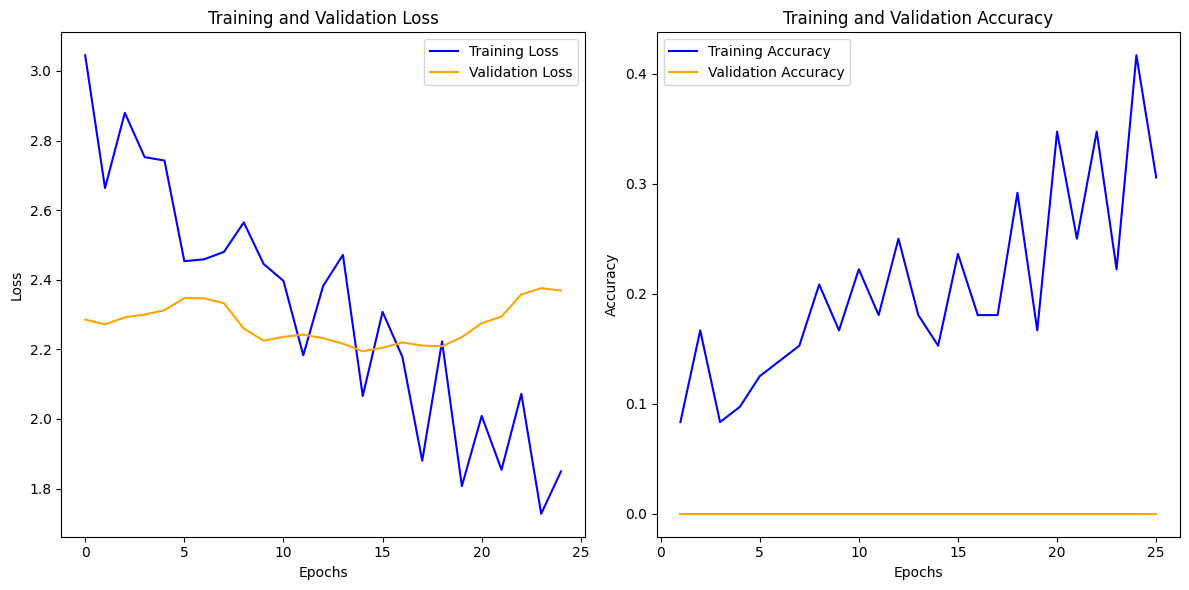

In [30]:
train_loss = history.history ['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape = (128,128,3))

# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [32]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)

In [35]:
from tensorflow.keras.models import Model
# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=x)

In [36]:
from tensorflow.keras.optimizers import Adam
# Compile the model
vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg = vgg_model.fit(train_ds, validation_data = val_ds, epochs = 100)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.0464 - loss: 2.4713 - val_accuracy: 0.5556 - val_loss: 1.6344
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5569 - loss: 1.5821 - val_accuracy: 0.5556 - val_loss: 1.3589
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6063 - loss: 1.3068 - val_accuracy: 0.7222 - val_loss: 1.0745
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7127 - loss: 1.1399 - val_accuracy: 0.7778 - val_loss: 0.8568
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7422 - loss: 0.9756 - val_accuracy: 0.7222 - val_loss: 0.8715
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7639 - loss: 0.8357 - val_accuracy: 0.6111 - val_loss: 1.0139
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7873 - loss: 0.7122 - val_accuracy: 0.6667 - val_loss: 0.9234
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9015 - loss: 0.6018 - val_accuracy: 0.7222 - val_loss: 

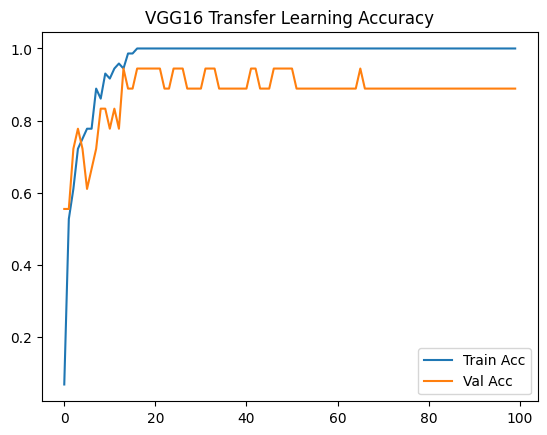

In [37]:
plt.plot(history_vgg.history['accuracy'], label='Train Acc')
plt.plot(history_vgg.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("VGG16 Transfer Learning Accuracy")
plt.show()

In [38]:
# Classification Report
y_true = []
y_pred = []

for images, labels in val_ds:
  preds = vgg_model.predict(images)
  preds_labels = np.argmax(preds, axis =1)
  y_true.extend(labels.numpy())
  y_pred.extend(preds_labels)

labels = list(range(len(class_names)))
print(classification_report(y_true, y_pred,labels = labels,  target_names = class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         0
     cupuacu       0.00      0.00      0.00         0
    graviola       0.00      0.00      0.00         0
     guarana       0.00      0.00      0.00         0
     pupunha       0.75      1.00      0.86         3
      tucuma       1.00      0.87      0.93        15

    accuracy                           0.89        18
   macro avg       0.29      0.31      0.30        18
weighted avg       0.96      0.89      0.92        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me